In [1]:
#import libraries
import warnings 
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import scipy.io as spio
import scipy.signal
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
import math 
import re 
import pandas as pd
import os
import glob
from os.path import expanduser
import datetime
import statistics as stats
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.patches as mpatches
from TUG_classes import *


In [2]:
def color_negative_red(val):
    color = 'red' if val > 110 else 'black'
    return 'color: %s' % color



## Dati anagrafici 

In [15]:

#load file 
home = expanduser("~")
id_patient = 'datadump-FDG-006-20230208-mr'
pth = home + '/dev_iit/assistive-rehab/data_exp/'+ id_patient
files = glob.glob(os.path.join(pth, '*.mat'))
lastfile = max(files, key=os.path.getctime)

#print personal data
i = [pos for pos, char in enumerate(lastfile) if char == "-"]
i1 = i[-3]
i2 = i[-2]
name = lastfile[i1+1:i2]
surname = ""
age = ""

personaldata = []
personaldata.append(name)
personaldata.append(surname)
personaldata.append(age)        
table = pd.DataFrame(personaldata) 
table.rename(index={0:"Nome",1:"Cognome",2:"Età"},  columns={0:"Paziente"}, inplace=True)
display(table) 

,Paziente
Nome,006
Cognome,
Età,


In [16]:

data = []
ctime = []
filename = []
tagex = []
files.sort(key=os.path.getctime)
for fi in files:
    i = [pos for pos, char in enumerate(fi) if char == "-"]
    i1 = i[-3]
    i2 = i[-2]
    i3 = i[-1]
    namei = fi[i1+1:i2]
    if namei == name:
        filename.append(fi)
        data.append(loadmat(fi)) #data.append(scipy.io.loadmat(fi))
        tagex.append(fi[i2+1:i3])
        ctime.append(os.path.getctime(fi))   

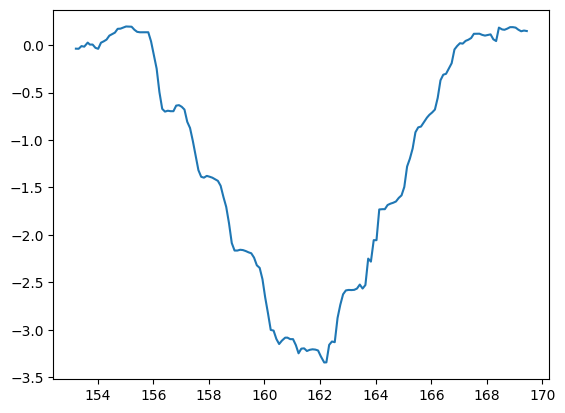

durata
9


/home/carmela/dev_iit/assistive-rehab/report/TUG_classes.py:283: RuntimeWarning:

invalid value encountered in scalar divide

/home/carmela/dev_iit/assistive-rehab/report/TUG_classes.py:288: RuntimeWarning:

invalid value encountered in scalar divide

/home/carmela/dev_iit/assistive-rehab/report/TUG_classes.py:294: RuntimeWarning:

invalid value encountered in scalar divide



In [18]:
time = []
month = []
exercises = []
ex_names = []
#count how many exercise of the same type were performed at that month
countexmonth = {
    "tug" : [0,0,0,0,0,0,0,0,0,0,0,0]
}

for i in range(len(data)):

    datai = data[i]
    time.append(datai['Time_samples'])
    monthi = datetime.date.fromtimestamp(ctime[i]).month-1
    month.append(monthi)
    shoulderCenter = datai['Keypoints']['shoulderCenter']
    head = datai['Keypoints']['head']
    shoulderLeft = datai['Keypoints']['shoulderLeft']
    shoulderRight = datai['Keypoints']['shoulderRight']
    elbowLeft = datai['Keypoints']['elbowLeft']
    handLeft = datai['Keypoints']['handLeft']
    elbowRight = datai['Keypoints']['elbowRight']
    handRight = datai['Keypoints']['handRight']
    hipLeft = datai['Keypoints']['hipLeft']
    hipRight = datai['Keypoints']['hipRight']
    ankleLeft = datai['Keypoints']['ankleLeft']
    ankleRight = datai['Keypoints']['ankleRight']
    kneeLeft = datai['Keypoints']['kneeLeft']
    kneeRight = datai['Keypoints']['kneeRight']
    footLeft = datai['Keypoints']['footLeft']
    footRight = datai['Keypoints']['footRight']
    hipCenter = datai['Keypoints']['hipCenter']

    key_pam = {
        "shoulderCenter" : shoulderCenter,
        "head" : head,
        "shoulderLeft" : shoulderLeft,
        "shoulderRight" : shoulderRight,
        "elbowLeft" : elbowLeft,
        "handLeft" : handLeft,
        "elbowRight" : elbowRight,
        "handRight" : handRight,
        "hipLeft" : hipLeft,
        "hipRight" : hipRight,
        "ankleLeft" : ankleLeft,
        "ankleRight" : ankleRight,
        "kneeLeft" : kneeLeft,
        "kneeRight" : kneeRight,
        "footLeft" : footLeft,
        "footRight" : footRight,
        "hipCenter" : hipCenter
    }
    s=Skeleton(key_pam)
    #s.show()
    
    plt.plot(time[0][:-1],s.getKeypoint('ankleLeft')[:,1])
    plt.show()

    samp2cut= 9
    in_stand_idx, in_wf_idx, fin_wf_idx, fin_turn1_idx, fin_wb_idx, fin_turn2_idx, fin_sit_idx = compute_timing(s, samp2cut)

    exname = datai["Exercise"]["name"]
    exname = re.sub(r'[^\w]','',exname)
    ex_names.append(exname)
    result_singleexercise = []
    allmet = datai["Exercise"]["metrics"]
    metrics = allmet.keys()
    for metname in metrics:

        if "step" in metname:
            flt = allmet[metname]["median_filter_window"]
            proj = allmet[metname]["enable_plane_projection"]
            proj = True
            tstanding = time[0][in_stand_idx]
            tforward = time[0][in_wf_idx]
            tturning1 = time[0][fin_wf_idx]
            tbackward = time[0][fin_turn1_idx]
            tturning2 = time[0][fin_wb_idx]
            tsitting = time[0][fin_turn2_idx]
            tend = time[0][fin_sit_idx]
            step_thresh = allmet[metname]["step_thresh"]
            step_thresh = 0.25
            durata = samp2cut #samples
            step = Step(flt, proj, tstanding, tforward, tturning1, tbackward, tturning2, tsitting, tend, step_thresh, durata)
            step.compute(s)
            stepmet = [step.step_distance, step.nsteps, step.cadence, step.speed, step.speed_z, step.walking_time, step.ex_time,
                       step.filtered_step_distance, step.strikes, step.step_width, step.step_length]
            result_singleexercise.append((step,stepmet))


    if exname == "tug":
        ex = Tug(monthi,result_singleexercise)

    countexmonth[exname][monthi] = 1 + countexmonth[exname][monthi]

    exercises.append(ex)   

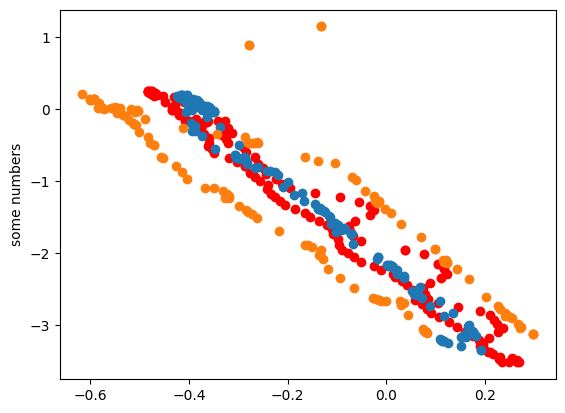

In [19]:
plt.plot(s.getKeypoint('shoulderCenter')[:,0], s.getKeypoint('shoulderCenter')[:,1],'ro')
plt.plot(s.getKeypoint('ankleLeft')[:,0], s.getKeypoint('ankleLeft')[:,1],'o')
plt.plot(s.getKeypoint('ankleRight')[:,0], s.getKeypoint('ankleRight')[:,1],'o')
plt.ylabel('some numbers')
plt.show()

/tmp/ipykernel_19211/150402632.py:7: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19211/150402632.py:18: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19211/150402632.py:29: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19211/150402632.py:40: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19211/150402632.py:51: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19211/150402632.py:62: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



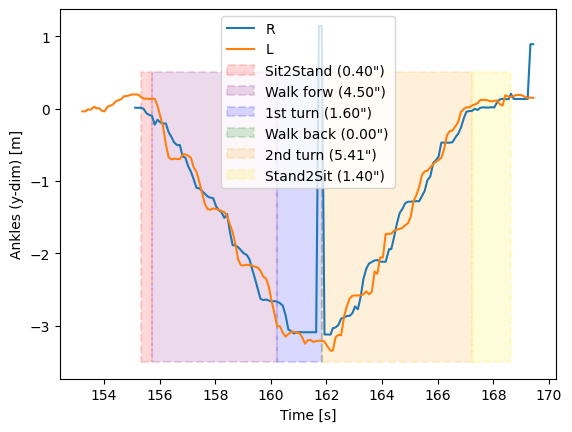

In [20]:
	
plt.plot(time[0][0:-1], s.getKeypoint('ankleRight')[:,1], label ='R')
plt.plot(time[0][0:-1], s.getKeypoint('ankleLeft')[:,1], label ='L')
plt.xlabel('Time [s]')
plt.ylabel('Ankles (y-dim) [m]')
left, bottom, width, height = (time[0][in_stand_idx], -3.5, time[0][in_wf_idx]-time[0][in_stand_idx], 4)
durata_fase = format(time[0][in_wf_idx]-time[0][in_stand_idx],'.2f')
rect1=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="red",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Sit2Stand ({durata_fase}")',
                       facecolor="red")
plt.gca().add_patch(rect1)
left, bottom, width, height = (time[0][in_wf_idx], -3.5, time[0][fin_wf_idx]-time[0][in_wf_idx], 4)
durata_fase = format(time[0][fin_wf_idx]-time[0][in_wf_idx],'.2f')
rect2=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="purple",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk forw ({durata_fase}")',
                       facecolor="purple")
plt.gca().add_patch(rect2)
left, bottom, width, height = (time[0][fin_wf_idx], -3.5, time[0][fin_turn1_idx]-time[0][fin_wf_idx], 4)
durata_fase = format(time[0][fin_turn1_idx]-time[0][fin_wf_idx],'.2f')
rect3=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="blue",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'1st turn ({durata_fase}")',
                       facecolor="blue")
plt.gca().add_patch(rect3)
left, bottom, width, height = (time[0][fin_turn1_idx], -3.5, time[0][fin_wb_idx]-time[0][fin_turn1_idx], 4)
durata_fase = format(time[0][fin_wb_idx]-time[0][fin_turn1_idx],'.2f')
rect4=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="green",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk back ({durata_fase}")',
                       facecolor="green")
plt.gca().add_patch(rect4)
left, bottom, width, height = (time[0][fin_wb_idx], -3.5, time[0][fin_turn2_idx]-time[0][fin_wb_idx], 4)
durata_fase= format(time[0][fin_turn2_idx]-time[0][fin_wb_idx],'.2f')
rect5=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="orange",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'2nd turn ({durata_fase}")',
                       facecolor="orange")
plt.gca().add_patch(rect5)
left, bottom, width, height = (time[0][fin_turn2_idx], -3.5, time[0][fin_sit_idx]-time[0][fin_turn2_idx], 4)
durata_fase= format(time[0][fin_sit_idx]-time[0][fin_turn2_idx],'.2f')
rect6=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="#FFEB00",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Stand2Sit ({durata_fase}")',
                       facecolor="#FFEB00")
plt.gca().add_patch(rect6)
plt.legend()
#plt.savefig("/home/carmela/dev_iit/assistive-rehab/EsempioFasiTUG.svg", format="svg")

 
## Report della seduta odierna

 
Di seguito si riporta il grafico:

In [232]:
lastsess_time = time[-1]
lastsess_result = exercises[-1].result
lastsess_res_step = []

%matplotlib inline
%matplotlib inline
for i in range(len(lastsess_result)):
    lastsess_met,lastsess_resi = lastsess_result[i]
    lastsess_metname = lastsess_met.name

    ################
    #     STEP     #
    ################
    if lastsess_metname == "step":
        dist=lastsess_resi[5]
        strikes=lastsess_resi[6]
        trace1 = go.Scatter(
            x=lastsess_time,y=dist,
            mode='lines',
            line=dict(
                color='blue',
                width=3
            ),
            name='Distanza tra i piedi'
        )
        trace2 = go.Scatter(
            x=lastsess_time[strikes],y=dist[strikes],
            mode='markers',
            marker=dict(
                color='red',
                size=10
            ),
            name='Appoggio tallone'
        )
        data = [trace1,trace2]
        layout = dict(
            width=750,
            height=600,
            autosize=False,
            title='Distanza tra i piedi',
            font=dict(family='Courier New, monospace', size=22, color='black'),
            xaxis=dict(
                title='time [s]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='dist [m]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        )
        fig = dict(data=data, layout=layout)
        iplot(fig)

        lastsess_res_step.append(lastsess_resi)
        sla = lastsess_res_step[0][8]
        ns = lastsess_res_step[0][1]
        cad = lastsess_res_step[0][2]
        sp = lastsess_res_step[0][3]
        ex = lastsess_res_step[0][4]
        tablestep = pd.DataFrame([sla, ns, cad, sp, ex])
        tablestep.rename(index={0:"Step Length Avg. [m]",1:"Number of steps",2:"Cadence [steps/s]",
                                3:"Speed [m/s]",4:"Execution time [s]"},
                         columns={0:"Gait analysis"}, inplace=True)
        display(tablestep)



TypeError: only integer scalar arrays can be converted to a scalar index

In [51]:
if exname == 'tug':

    table_tug = pd.DataFrame([['Normale mobilità'],['Buona mobilita'],['Ausili cammino'],['Rischio caduta']],
             index=['< 10 s','< 20 s','< 30 s','>= 30 s'],
             columns=['Tabella TUG'])
    display(table_tug)

    time_score = lastsess_res_step[0][4]
    print("Il test è stato svolto in",round(time_score,2),"s")
    if time_score < 10:
        evaluation = 'Normale mobilità'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 20:
        evaluation = 'Buona mobilità, non necessita ausili'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 30:
        evaluation = 'Necessita ausili cammino'
        print("La valutazione è [1;30;43m",evaluation)
    elif time_score >= 30:
        evaluation = 'Rischio caduta'
        print("La valutazione è [1;30;41m",evaluation)


,Tabella TUG
< 10 s,Normale mobilità
< 20 s,Buona mobilita
< 30 s,Ausili cammino
>= 30 s,Rischio caduta


Il test è stato svolto in 16.81 s
La valutazione è  Buona mobilità, non necessita ausili
